# Random Forest

### Imports

In [1]:
! pip install graphviz
! pip install dl8.5
! pip install chefboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time as t
import random

! pip install graphviz

from IPython.display import SVG
from graphviz import Source

from sklearn import tree
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

### Helper Functions

In [3]:
translations = {
    'Driving_to' : ['No Urgent Place', 'Home', 'Work'],
    'Passanger' : ['Alone', 'Partner', 'Kid(s)', 'Friend(s)'],
    'Weather' : ['Sunny', 'Rainy', 'Snowy'],
    'Time' : ['7AM', '10AM', '2PM', '6PM', '10PM'],
    'Coupon' : ['Restaurant(<20)', 'Restaurant(20-50)', 'Carry out & Take away', 'Bar', 'Coffee House'],
    'Coupon_validity' : ['2h', '1d'],
    'Gender' : ['Male', 'Female'],
    'Age' : ['below21', '21', '26', '31', '36', '41', '46', '50plus'],
    'Maritalstatus' : ['Single', 'Divorced', 'Widowed', 'Unmarried partner', 'Married partner'],
    'Education' : ['Some High School', 'High School Graduate', 'Some college - no degree', 'Associates degree', 'Bachelors degree', 'Graduate degree (Masters or Doctorate)'],
    'Occupation' : ['Unemployed', 'Construction & Extraction', 'Arts Design Entertainment Sports & Media', 'Food Preparation & Serving Related', 'Education&Training&Library', 'Sales & Related', 'Computer & Mathematical', 'Student', 'Architecture & Engineering', 'Business & Financial', 'Office & Administrative Support', 'Retired', 'Management', 'Life Physical Social Science', 'Healthcare Support', 'Building & Grounds Cleaning & Maintenance', 'Legal', 'Installation Maintenance & Repair', 'Protective Service', 'Healthcare Practitioners & Technical', 'Community & Social Services', 'Transportation & Material Moving', 'Personal Care & Service', 'Farming Fishing & Forestry', 'Production Occupations'],
    'Income' : ['Less than $12500', '$12500 - $24999', '$25000 - $37499', '$37500 - $49999', '$50000 - $62499', '$62500 - $74999', '$75000 - $87499', '$87500 - $99999', '$100000 or More'],
}

modes = {'id': 1, 
         'Decision': 1, 
         'Driving_to': 'No Urgent Place', 
         'Passanger': 'Alone', 
         'Weather': 'Sunny', 
         'Temperature': 80, 
         'Time': '6PM', 
         'Coupon': 'Coffee House', 
         'Coupon_validity': '1d', 
         'Gender': 'Female', 
         'Age': '21', 
         'Maritalstatus': 'Married partner', 
         'Children': 0, 
         'Education': 'Some college - no degree', 
         'Occupation': 'Unemployed', 
         'Income': '$25000 - $37499', 
         'Bar': 0.0, 
         'Coffeehouse': 1.0, 
         'Carryaway': 2.0, 
         'Restaurantlessthan20': 2.0, 
         'Restaurant20to50': 1.0, 
         'Direction_same': 0, 
         'Distance': 2}

def accuracy(y_actual, y_predicted):
    if(not len(y_actual) == len(y_predicted)):
        print("Lengths don't match")
        return 0
    correct = 0
    for i in range(len(y_actual)):
        if y_actual[i] == y_predicted[i]:
            correct += 1
    return 1.0 * correct / len(y_actual)

def clean_df(df):
    for (field, vals) in df.iteritems():
        for v_ind in vals.index:
            if pd.isna(vals[v_ind]):
                # NaN condition
                df.at[v_ind, field] = modes[field]
        if field in translations:
            strings = []
            for s_ind in vals.index:
                if vals[s_ind] not in translations[field]:
                    # String that wasn't in training data
                    df.at[s_ind, field] = 0
                    continue
                df.at[s_ind, field] = translations[field].index(vals[s_ind])
    return df

def make_rfc(num_trees, max_depth):#, max_leaves):
    rfc = RandomForestClassifier()
    rfc.criterion = 'entropy'
    rfc.max_tree_depth = max_depth
    rfc.n_estimators = num_trees
#     rfc.max_leaf_nodes = max_leaves
    return rfc

### Data Importing and Processing

In [4]:
start_time = t.time()
df = pd.read_csv("../data/train.csv")
df_test = pd.read_csv("../data/test.csv")

# print(df)

### Data Processing

In [5]:
# Remove the id column

df = df.loc[:, df.columns != 'id']
df_test = df_test.loc[:, df_test.columns != 'id']

# Make string values into numbers

clean_df(df)
clean_df(df_test)

# Not 10 like normal since we already have a test partition
num_folds = 9 

cv_length = 1.0 * df.shape[0] / num_folds

partitions = [df.iloc[int(i * cv_length):int((i+1) * cv_length),:] for i in range(num_folds)]
# print([len(partitions[i]) for i in range(len(partitions))])


### Model

In [6]:
# Rotate the folds to tune the parameters

results = []
max_tree_depths = range(5, 25)
num_trees = [1, 2, 3, 4, 6, 8, 12, 16, 24, 32, 48, 64, 96, 128]
# max_leaf_nodes = range(2, 1003, 10)
num_coord_descs = 4
opt_num_trees = random.choice(num_trees)
opt_tree_depth = random.choice(max_tree_depths)
plot_data = [[], []]
# opt_num_leaves = random.choice(max_leaf_nodes)

# should return the optimal value
# r is the range to iterate over
# ind is zero indexed
# n_estimators, max_depth, max_leaf_nodes
def descend_on_index(r, ind):
    results = []
    # (n, depth, leaf_nodes=None)
    input_array = [opt_num_trees, opt_tree_depth]
    for i in range(num_folds):
        validation = partitions[i]
        training = pd.concat([j for j in partitions if not j.equals(validation)])

        y_train = training['Decision']
        X_train = training.loc[:, df.columns != 'Decision']

        y_valid = validation['Decision']
        X_valid = validation.loc[:, df.columns != 'Decision']

        results_for_fold = []

        for n in r:
            input_array[ind] = n
            abc = make_rfc(input_array[0], input_array[1])
            abc.fit(X_train, y_train)
            a = accuracy(np.array(y_valid), abc.predict(X_valid))
            results_for_fold += [a]
            print("Accuracy for {:4d} estimators with depth {:2d} on fold {:2d} is {:.3f}".format(input_array[0], input_array[1], i, a))
            print("Training accuracy: {:.3f}".format(accuracy(np.array(y_train), abc.predict(X_train))))
        results += [results_for_fold]
        
    results_for_n = np.array(results).T
    avg_acc = [np.mean(results_for_n[j]) for j in range(len(results_for_n))]
    plot_data[ind] = avg_acc
    opt = r[avg_acc.index(np.max(avg_acc))]
    print("Optimal number on index {:}: {:}".format(ind, opt))
    return opt


for c in range(num_coord_descs):
    print("Number descent:", c)
    prev_num_trees = opt_num_trees
    opt_num_trees = descend_on_index(num_trees, 0)
    if prev_num_trees == opt_num_trees:
        break
    prev_tree_depth = opt_tree_depth
    opt_tree_depth = descend_on_index(max_tree_depths, 1)
    if prev_tree_depth == opt_tree_depth:
        break

Number descent: 0
Accuracy for    1 estimators with depth 11 on fold  0 is 0.637
Training accuracy: 0.862
Accuracy for    2 estimators with depth 11 on fold  0 is 0.626
Training accuracy: 0.862
Accuracy for    3 estimators with depth 11 on fold  0 is 0.674
Training accuracy: 0.938
Accuracy for    4 estimators with depth 11 on fold  0 is 0.655
Training accuracy: 0.942
Accuracy for    6 estimators with depth 11 on fold  0 is 0.704
Training accuracy: 0.971
Accuracy for    8 estimators with depth 11 on fold  0 is 0.723
Training accuracy: 0.982
Accuracy for   12 estimators with depth 11 on fold  0 is 0.744
Training accuracy: 0.993
Accuracy for   16 estimators with depth 11 on fold  0 is 0.751
Training accuracy: 0.995
Accuracy for   24 estimators with depth 11 on fold  0 is 0.756
Training accuracy: 0.997
Accuracy for   32 estimators with depth 11 on fold  0 is 0.755
Training accuracy: 0.998
Accuracy for   48 estimators with depth 11 on fold  0 is 0.761
Training accuracy: 0.999
Accuracy for  

Accuracy for   32 estimators with depth 11 on fold  6 is 0.733
Training accuracy: 0.998
Accuracy for   48 estimators with depth 11 on fold  6 is 0.737
Training accuracy: 0.999
Accuracy for   64 estimators with depth 11 on fold  6 is 0.744
Training accuracy: 0.999
Accuracy for   96 estimators with depth 11 on fold  6 is 0.745
Training accuracy: 0.999
Accuracy for  128 estimators with depth 11 on fold  6 is 0.753
Training accuracy: 0.999
Accuracy for    1 estimators with depth 11 on fold  7 is 0.617
Training accuracy: 0.864
Accuracy for    2 estimators with depth 11 on fold  7 is 0.595
Training accuracy: 0.863
Accuracy for    3 estimators with depth 11 on fold  7 is 0.678
Training accuracy: 0.937
Accuracy for    4 estimators with depth 11 on fold  7 is 0.639
Training accuracy: 0.940
Accuracy for    6 estimators with depth 11 on fold  7 is 0.674
Training accuracy: 0.970
Accuracy for    8 estimators with depth 11 on fold  7 is 0.681
Training accuracy: 0.983
Accuracy for   12 estimators wit

Accuracy for   96 estimators with depth  5 on fold  3 is 0.744
Training accuracy: 0.999
Accuracy for   96 estimators with depth  6 on fold  3 is 0.742
Training accuracy: 0.999
Accuracy for   96 estimators with depth  7 on fold  3 is 0.746
Training accuracy: 0.999
Accuracy for   96 estimators with depth  8 on fold  3 is 0.749
Training accuracy: 0.999
Accuracy for   96 estimators with depth  9 on fold  3 is 0.739
Training accuracy: 0.999
Accuracy for   96 estimators with depth 10 on fold  3 is 0.744
Training accuracy: 0.999
Accuracy for   96 estimators with depth 11 on fold  3 is 0.748
Training accuracy: 0.999
Accuracy for   96 estimators with depth 12 on fold  3 is 0.739
Training accuracy: 0.999
Accuracy for   96 estimators with depth 13 on fold  3 is 0.752
Training accuracy: 0.999
Accuracy for   96 estimators with depth 14 on fold  3 is 0.754
Training accuracy: 0.999
Accuracy for   96 estimators with depth 15 on fold  3 is 0.747
Training accuracy: 0.999
Accuracy for   96 estimators wit

Accuracy for   96 estimators with depth 19 on fold  7 is 0.731
Training accuracy: 0.999
Accuracy for   96 estimators with depth 20 on fold  7 is 0.739
Training accuracy: 0.999
Accuracy for   96 estimators with depth 21 on fold  7 is 0.744
Training accuracy: 0.999
Accuracy for   96 estimators with depth 22 on fold  7 is 0.738
Training accuracy: 0.999
Accuracy for   96 estimators with depth 23 on fold  7 is 0.736
Training accuracy: 0.999
Accuracy for   96 estimators with depth 24 on fold  7 is 0.738
Training accuracy: 0.999
Accuracy for   96 estimators with depth  5 on fold  8 is 0.751
Training accuracy: 0.999
Accuracy for   96 estimators with depth  6 on fold  8 is 0.769
Training accuracy: 0.999
Accuracy for   96 estimators with depth  7 on fold  8 is 0.751
Training accuracy: 0.999
Accuracy for   96 estimators with depth  8 on fold  8 is 0.746
Training accuracy: 0.999
Accuracy for   96 estimators with depth  9 on fold  8 is 0.756
Training accuracy: 0.999
Accuracy for   96 estimators wit

Accuracy for   64 estimators with depth 16 on fold  4 is 0.739
Training accuracy: 0.999
Accuracy for   96 estimators with depth 16 on fold  4 is 0.741
Training accuracy: 0.999
Accuracy for  128 estimators with depth 16 on fold  4 is 0.746
Training accuracy: 0.999
Accuracy for    1 estimators with depth 16 on fold  5 is 0.647
Training accuracy: 0.872
Accuracy for    2 estimators with depth 16 on fold  5 is 0.589
Training accuracy: 0.857
Accuracy for    3 estimators with depth 16 on fold  5 is 0.675
Training accuracy: 0.939
Accuracy for    4 estimators with depth 16 on fold  5 is 0.663
Training accuracy: 0.943
Accuracy for    6 estimators with depth 16 on fold  5 is 0.665
Training accuracy: 0.967
Accuracy for    8 estimators with depth 16 on fold  5 is 0.708
Training accuracy: 0.984
Accuracy for   12 estimators with depth 16 on fold  5 is 0.709
Training accuracy: 0.990
Accuracy for   16 estimators with depth 16 on fold  5 is 0.717
Training accuracy: 0.996
Accuracy for   24 estimators wit

Accuracy for  128 estimators with depth 19 on fold  1 is 0.752
Training accuracy: 0.999
Accuracy for  128 estimators with depth 20 on fold  1 is 0.762
Training accuracy: 0.999
Accuracy for  128 estimators with depth 21 on fold  1 is 0.748
Training accuracy: 0.999
Accuracy for  128 estimators with depth 22 on fold  1 is 0.758
Training accuracy: 0.999
Accuracy for  128 estimators with depth 23 on fold  1 is 0.749
Training accuracy: 0.999
Accuracy for  128 estimators with depth 24 on fold  1 is 0.755
Training accuracy: 0.999
Accuracy for  128 estimators with depth  5 on fold  2 is 0.735
Training accuracy: 0.999
Accuracy for  128 estimators with depth  6 on fold  2 is 0.729
Training accuracy: 0.999
Accuracy for  128 estimators with depth  7 on fold  2 is 0.742
Training accuracy: 0.999
Accuracy for  128 estimators with depth  8 on fold  2 is 0.736
Training accuracy: 0.999
Accuracy for  128 estimators with depth  9 on fold  2 is 0.730
Training accuracy: 0.999
Accuracy for  128 estimators wit

Accuracy for  128 estimators with depth 13 on fold  6 is 0.755
Training accuracy: 0.999
Accuracy for  128 estimators with depth 14 on fold  6 is 0.754
Training accuracy: 0.999
Accuracy for  128 estimators with depth 15 on fold  6 is 0.752
Training accuracy: 0.999
Accuracy for  128 estimators with depth 16 on fold  6 is 0.747
Training accuracy: 0.999
Accuracy for  128 estimators with depth 17 on fold  6 is 0.752
Training accuracy: 0.999
Accuracy for  128 estimators with depth 18 on fold  6 is 0.760
Training accuracy: 0.999
Accuracy for  128 estimators with depth 19 on fold  6 is 0.752
Training accuracy: 0.999
Accuracy for  128 estimators with depth 20 on fold  6 is 0.750
Training accuracy: 0.999
Accuracy for  128 estimators with depth 21 on fold  6 is 0.745
Training accuracy: 0.999
Accuracy for  128 estimators with depth 22 on fold  6 is 0.753
Training accuracy: 0.999
Accuracy for  128 estimators with depth 23 on fold  6 is 0.760
Training accuracy: 0.999
Accuracy for  128 estimators wit

Accuracy for  128 estimators with depth 12 on fold  2 is 0.747
Training accuracy: 0.999
Accuracy for    1 estimators with depth 12 on fold  3 is 0.627
Training accuracy: 0.861
Accuracy for    2 estimators with depth 12 on fold  3 is 0.622
Training accuracy: 0.864
Accuracy for    3 estimators with depth 12 on fold  3 is 0.696
Training accuracy: 0.938
Accuracy for    4 estimators with depth 12 on fold  3 is 0.671
Training accuracy: 0.941
Accuracy for    6 estimators with depth 12 on fold  3 is 0.708
Training accuracy: 0.969
Accuracy for    8 estimators with depth 12 on fold  3 is 0.692
Training accuracy: 0.982
Accuracy for   12 estimators with depth 12 on fold  3 is 0.693
Training accuracy: 0.993
Accuracy for   16 estimators with depth 12 on fold  3 is 0.726
Training accuracy: 0.996
Accuracy for   24 estimators with depth 12 on fold  3 is 0.717
Training accuracy: 0.998
Accuracy for   32 estimators with depth 12 on fold  3 is 0.741
Training accuracy: 0.999
Accuracy for   48 estimators wit

### Visualization

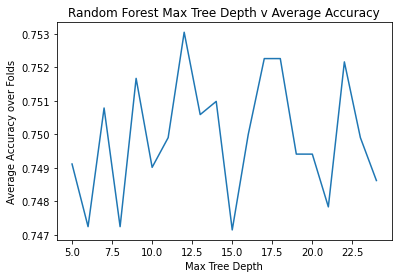

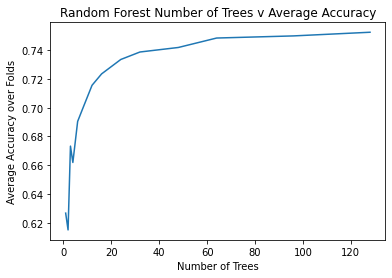

In [11]:
plt.plot(max_tree_depths, plot_data[1])
plt.title("Random Forest Max Tree Depth v Average Accuracy")
plt.xlabel("Max Tree Depth")
plt.ylabel("Average Accuracy over Folds")
plt.savefig('rf_tree_depth.png')
plt.show()
plt.plot(num_trees, plot_data[0])
plt.title("Random Forest Number of Trees v Average Accuracy")
plt.xlabel("Number of Trees")
plt.ylabel("Average Accuracy over Folds")
plt.savefig('rf_n_trees.png')
plt.show()

### Test

In [8]:
X_test = df_test.loc[:, df_test.columns != 'Decision']

y_train = df['Decision']
X_train = df.loc[:, df.columns != 'Decision']

rfc = make_rfc(opt_num_trees, opt_tree_depth)
rfc.fit(X_train, y_train)

results = rfc.predict(X_test)
print("Runtime is {:} seconds".format(t.time() - start_time))

Runtime is 501.0779182910919 seconds


### Format for Output

In [9]:
df_test['Decision'] = results
df_test['id'] = range(1, df_test.shape[0] + 1)
df_test = df_test[['id', 'Decision']]
print(df_test)

df_test.to_csv(r"../data/random_forest_results_4.csv", index = False)

        id  Decision
0        1         0
1        2         1
2        3         1
3        4         1
4        5         1
...    ...       ...
2495  2496         1
2496  2497         0
2497  2498         1
2498  2499         1
2499  2500         0

[2500 rows x 2 columns]
